In [1]:
from pysjef import Project, DirectoryNode, all_completed
from pysjef_molpro import no_errors
import numpy

In [2]:
root = DirectoryNode('dihedral_scan')

In [3]:
grid = numpy.linspace(0, 90, 18, endpoint=False)
for i, D in enumerate(grid):
    p = root.add_child(f'd{i}', suffix='molpro')
    p.write_input(
    f"""geometry={{
        H1
        C1 H1 rch
        C2 C1 rcc H1 A
        H2 C2 rch C1 A H1 D
        H3 C2 rch C1 A H2 180
        H4 C1 rch C2 A H1 180}}
    rch = 2.05; rcc = 2.65; A = 121.5; D ={D}+.01;
    basis = cc-pVTZ
    rhf
    set, mcocc=[3,2,2,2], mcclosed=[3,1,1,2], mcsym=1
    casscf,so_sci
    {{optg; inactive, D}}
    set,mcsym=[1,4]
    casscf,so_sci
    {{mrci; wf, sym=1;}}
    {{mrci; wf, sym=4;}}""")

In [4]:
from multiprocessing.dummy import Pool
from operator import methodcaller
with Pool(processes=8) as pool:
    pool.map(methodcaller('run', backend='local', wait=True),
             root.children, 1)
print('all completed', all_completed(root.children))
print('without errors', no_errors(root.children))

all completed True
without errors True


<IPython.core.display.Javascript object>


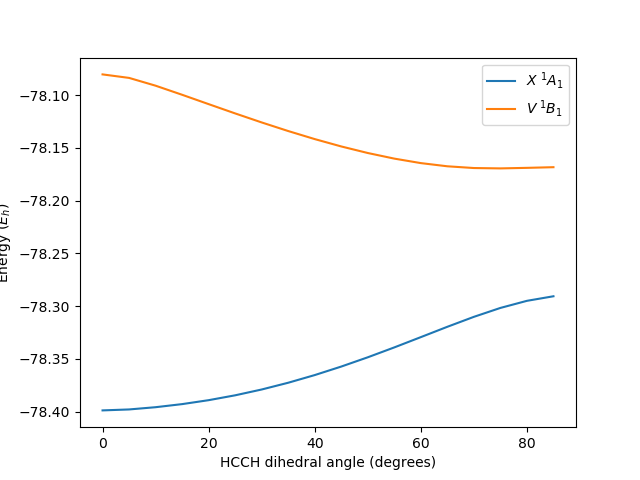

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook
energies = root.select(
    '//jobstep[command=MRCI]/property[name=Energy].value')
e1, e2 = energies[::2], energies[1::2]
cc = root.select('//variable[name=rcc]/value..')
plt.plot(grid, e1, grid, e2)
plt.legend([r'$X\;{}^1A_1$',r'$V\;{}^1B_1$'])
plt.xlabel('HCCH dihedral angle (degrees)')
plt.ylabel(r'Energy $(E_h)$')
plt.show()